# **Computer Vision Project Stage 3**

---

```
Aparajitha Sriram
Chandan Mannem - 801165621
Monesa Thoguluva Janardhanan
Sai Krishna Uddagiri - 801167439
```



### **A little bit about crowd counting:**

Crowd counting is the technique to count or give an estimate for the number of people in a large gathering from a picture or video like a surveillance feed.

It is useful for analyzing and estimating the number of people who attend a session or a public event. This will help to understand what kind of sessions attract larger crowds and which do not.

Crowd counting is also useful in crowd management in large public gatherings or protests and to help in coming up with efficient evacuation routes in case of emergencies.

<img src=https://www.epfl.ch/labs/cvlab/wp-content/uploads/2019/09/crowd_density_cover.jpg width=700px>

### **First steps:**
We mount our drive and fetch the dataset from the drive as we have a very huge dataset and we have to run in GPU.

Files like density map file and the weight files get generated from the code and they are present in the drive.

Please mount the drive present here: 
https://drive.google.com/drive/folders/1Z9nO0EpTdyabp7zkAcki-e_CoDEv2nUo, 
for the Shangai dataset.

In [ ]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
import torch
from tqdm import tqdm
%matplotlib inline
import scipy.spatial

### **Defining the gaussian_filter_density function**

gaussian_filter_density function generates density map for each image using the ground truth values. It is a very time consuming function. For 300 images, the method ran for almost 2 and a half hours.

### CSRNet
<i>We are following the CSRNet model proposed by the paper: 

<a href="https://arxiv.org/abs/1802.10062">CSRNet: Dilated Convolutional Neural Networks for Understanding the Highly Congested Scenes</a>

Li, Yuhong, Xiaofan Zhang, and Deming Chen. "Csrnet: Dilated convolutional neural networks for understanding the highly congested scenes." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.</i>

In [ ]:
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [ ]:
pwd

'/content'

In [ ]:
root = '/content/drive/My Drive/dataset/'

In [ ]:
root

'/content/drive/My Drive/dataset/'

Here we get all the images from the drive. 

In [ ]:
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [ ]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

print(img_paths[:5])

['/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_109.jpg', '/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_106.jpg', '/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_108.jpg', '/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_102.jpg', '/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_10.jpg']


Here we get all the images from the image path and for each image the corresponding ground truth image of that file is read using spacy.io.loadmat (the ground truth file is a matlab file for this dataset). 

The values of the mat files are assigned to the K numpy array and this K is sent to the gaussian_filter_density to generate the density heatmap for all the images.

<i>**Desity mapping** is a way of visually presenting points or lines may be concentrated in a given area. Here, it is used to give an idea of the how the crowd concentration is distributed across each image.</i>

As mentioned earlier, this function takes a very long time to run, it took us almost 2 and half hours for 500 images.

Once this funtion runs to completion, then for each image a .h5 file will be generated and all the .h5 files for the image files are present in the same folder in the drive.

Here is an example of just one image on how a mat file is read and how a density is created.

Image taken from the sample folder in the drive

In [ ]:
img_path = "/content/drive/My Drive/dataset/sample/IMG_59.jpg"
print (img_path)
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
print("Loading Mat file...")
# print(mat)
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["image_info"][0,0][0,0][0]
print("taking just the values from the mat files")
print(gt)
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
print(k)
print("applying gaussian_filter_density for K")
k = gaussian_filter_density(k)
with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
        hf['density'] = k
print("density file created.. Check drive for h5 file generation")

/content/drive/My Drive/dataset/sample/IMG_59.jpg
Loading Mat file...
taking just the values from the mat files
[[  91.49830949  588.28898326]
 [  34.7434012   412.4600517 ]
 [  79.25705476  291.16034575]
 [ 133.78628037  267.79067764]
 [ 159.38163116  285.59613906]
 [ 212.79801543  257.77510558]
 [ 170.51004455  434.71687848]
 [ 231.7163182   440.28108517]
 [ 260.65019301  436.94256116]
 [ 260.65019301  520.40566158]
 [ 310.72805326  588.28898326]
 [ 348.56465879  399.10595563]
 [ 429.80207653  426.92698911]
 [ 516.60370097  491.47178677]
 [ 472.09004741  465.87643597]
 [ 532.18347972  420.24994107]
 [ 644.58045495  450.29665723]
 [ 673.51432976  483.68189739]
 [ 762.54163688  619.44854075]
 [ 847.11757864  541.54964702]
 [ 900.53396291  485.90758007]
 [ 833.76348258  460.31222928]
 [ 770.33152625  471.44064267]
 [ 779.23425697  396.88027296]
 [ 963.96591923  468.10211865]
 [ 918.33942434  412.4600517 ]
 [ 949.49898183  389.09038358]
 [ 910.54953496  377.96197019]
 [ 853.79462668  366

Running the same function in a loop and getting the density files for all the images present. As we have run this function earlier, the previously generated .h5 files are stored in the drive, so there is no need to generate them again.

In [ ]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

### **A sample image and its ground truth heatmap:**

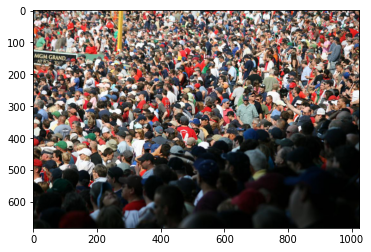

In [ ]:
plt.imshow(Image.open(img_paths[0]))

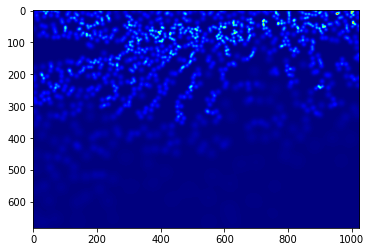

In [ ]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

Trying to find how many people are present in this image using the groundtruth values by summing it all up.

In [ ]:
np.sum(groundtruth)

904.1688

The next step is to train our model. The code is implemented in train.py file. And we have run this train.py file by passing the arguments. We trained this model for 10 epochs. For 10 epochs, the model took around 2 hours to complete. The best MAE that we could get is 89.718.

This train.py file is from the reference https://github.com/leeyeehoo/CSRNet-pytorch, also related to the research paper mentioned earlier.

Once the below code is implemented, then a pretrained weight file will be generated in the name of 0model_best.pth.tar

### **`Note: Please do not run the below cell as this will take hours to train the model`**

In [ ]:
!python3 "/content/drive/My Drive/dataset/train.py" "/content/drive/My Drive/dataset/part_a_train.json" "/content/drive/My Drive/dataset/part_a_val.json" 0 0 

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 0, processed 0 samples, lr 0.0000001000
/content/drive/My Drive/dataset/image.py:12: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  gt_file = h5py.File(gt_path)
Epoch: [0][0/1200]	Time 4.017 (4.017)	Data 3.740 (3.740)	Loss 86.8357 (86.8357)	
Epoch: [0][30/1200]	Time 3.628 (3.084)	Data 3.194 (2.735)	Loss 124.2836 (635.8970)	
Epoch: [0][60/1200]	Time 1.202 (3.177)	Data 0.039 (2.801)	Loss 134.6521 (449.1717)	
Epoch: [0][90/1200]	Time 3.320 (3.046)	Data 3.168 (2.654)	Loss 15.6632 (387.8

## **Validating the results**

In [ ]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [ ]:
#defining the location of dataset
root = '/content/drive/My Drive/dataset/'
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test]

In [ ]:
#defining the image path
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [ ]:
import h5py
import torch
import shutil

def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best,task_id, filename='checkpoint.pth.tar'):
    torch.save(state, task_id+filename)
    if is_best:
        shutil.copyfile(task_id+filename, task_id+'model_best.pth.tar')            

In [ ]:
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)                

In [ ]:
model = CSRNet()

In [ ]:
#defining the model
model = model.cuda()

The pretrained weight file is /content/drive/My Drive/dataset/0model_best.pth.tar location. So fetching the weight values from it.

In [ ]:
#loading the trained weights
checkpoint = torch.load('/content/drive/My Drive/dataset/0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

100%|██████████| 182/182 [09:37<00:00,  3.17s/it]

102.54129592140953


In [ ]:
print (mae/len(img_paths))

102.54129592140953


Predicted Count :  266


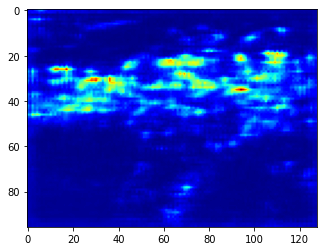

Original Count :  205


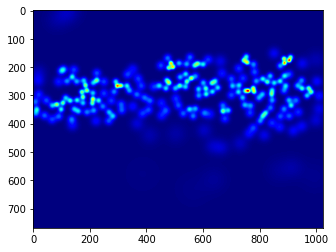

Original Image


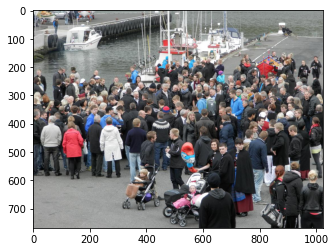

In [ ]:
from matplotlib import cm as c
img = transform(Image.open('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_77.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/My Drive/dataset/part_A_final/test_data/ground_truth/IMG_77.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_77.jpg'))
plt.show()

As you can see in the above scenario, since we have ran it for only 10 epochs the mae value was high and the model was doing okayish. 

The predicted value is 266 while the actual value is 205. So we planned to run it for more epochs. We ran it for 400 epochs and stored the pretrained weight file in the drive. It took us a day to finish training the model.

In [ ]:
model_another = CSRNet()

In [ ]:
#defining the model
model_another = model_another.cuda()

In [ ]:
#loading the trained weights
checkpoint_multiple = torch.load('/content/drive/My Drive/dataset/Downloaded weight/0model_best.pth.tar')
model_another.load_state_dict(checkpoint_multiple['state_dict'])

<All keys matched successfully>

In [ ]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model_another(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

100%|██████████| 182/182 [00:59<00:00,  3.08it/s]

75.69089818262792


In [ ]:
print (mae/len(img_paths))

75.69089818262792


Predicted Count :  216


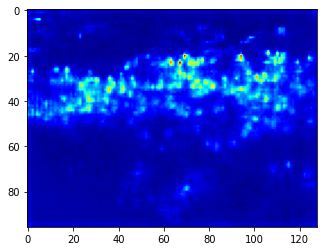

Original Count :  205


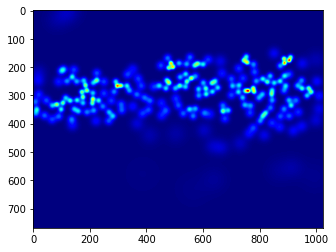

Original Image


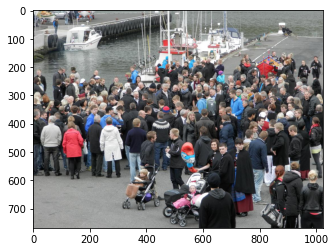

In [ ]:
from matplotlib import cm as c
img = transform(Image.open('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_77.jpg').convert('RGB')).cuda()

output = model_another(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/My Drive/dataset/part_A_final/test_data/ground_truth/IMG_77.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/My Drive/dataset/part_A_final/test_data/images/IMG_77.jpg'))
plt.show()

As we can see, the MAE value after running 400 epochs is much better compared to the 10 epochs and the accuracy has been increased. For the same image, the predicted value is now 216.

Our next goal is trying to run this for our dataset.

### **Currently...**
We are currently trying to generate density maps for the images in our dataset, **JHU-CROWD++: A large-scale unconstrained crowd counting dataset**, present <a href="http://www.crowd-counting.com/#download">here</a>. 

We are in the process of generating it for first 100 images and then try running the model to see how the prediction is.

The following is the generation of density maps in progress... it has been running for a day at the time of submission...

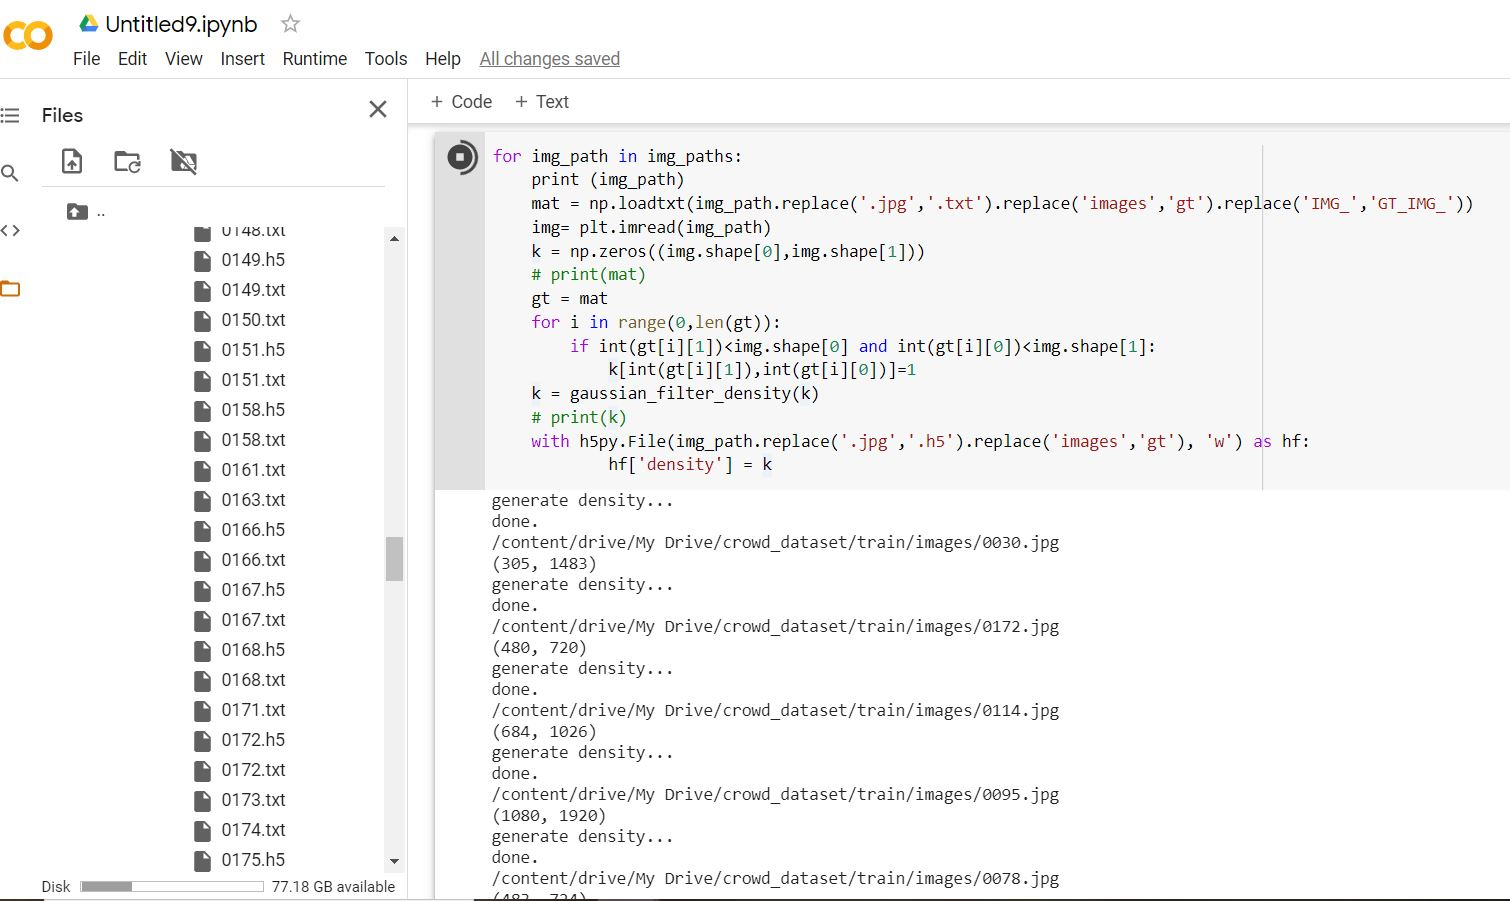

### **Next Steps**

We are planning to run the model for the 100 images for which we generated the density maps. Based on the prediction, our plan is to consider more images for the model to train on as our dataset contains 2k+ images.